# Subgroup B Question 2


Addressing Subgroup B Question 2: Optimization of Attraction Layouts and Schedules


*   Simulate guest flow under different layouts or schedules using queueing theory or agent-based modeling
*   Assess the impact on wait times, satisfaction, and revenue



Key Factors affecting demand of attraction/services (From Subgroup B Question 1)



## Loading Libraries

In [ ]:
!pip install simpy
!pip install mesa==1.2.1
!pip install matplotlib
!pip install adjustText

# Importing Libraries
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from matplotlib.patches import Wedge, Circle
from adjustText import adjust_text
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from matplotlib import cm
import simpy
import random
import math
import datetime
import scipy.stats as stats
import heapq
from collections import defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.8 MB/s eta 0:00:00


## Loading Dataset

USS Attraction/Services Data:

1.   List of all rides and restaurant or shop services present and operating in 2025.
2.  Data includes Name of Attraction/Services, Type, Capacity, Interval and Distance from Entrance.

Capacity and Interval of the attraction/services are estimated. (Online pictures and a typical average of operations)

*Interval of slides = Duration of Ride + Estimated of 7 minute buffer (Getting on and off rides + safety protocols)

Unlike the attractions (typically rides), Restaurant/Shops does not have a fixed duration per session, hence estimation of visitors' duration of stay was used to replace the missing values.



### Survey Response Data


In [ ]:
survey_data = pd.read_excel("uss_survey_responses.xlsx")
survey_data.head()

Timestamp               Email Address  \
0  2025-01-03 21:58:00       tada.maenth@gmail.com   
1  2025-01-03 23:33:00        amelia.low@gmail.com   
2  2025-03-03 20:46:00     funwenxin2003@gmail.com   
3  2025-03-03 21:54:00  tianyuan.zhang03@gmail.com   
4  2025-03-03 21:58:00   chia.kwang.yang@gmail.com   

  Question 1: Which type of theme park visitor best describes you?  \
0                                     Solo Traveller                 
1                              Visiting With Friends                 
2                              Visiting With Friends                 
3                              Visiting With Friends                 
4                                     Solo Traveller                 

  Question 2: What is your age range?  \
0                  21 To 34 Years Old   
1                  21 To 34 Years Old   
2                  21 To 34 Years Old   
3                  21 To 34 Years Old   
4                  21 To 34 Years Old   

  Question 3:  Are you a tourist or a local?  \
0                                      Local   
1                                      Local   
2                                      Local   
3                                      Local   
4                                      Local   

  Question 4.1: For the category on thrill rides, what is the average time you queued for?   \
0                                    5 To 10 Minutes                                          
1                                   20 To 30 Minutes                                          
2                                   20 To 30 Minutes                                          
3                                   10 To 20 Minutes                                          
4                                   20 To 30 Minutes                                          

  Question 4.2: For the category on interactive exhibits, what is the average time you queued for?   \
0                                   10 To 20 Minutes                                                  
1                                    5 To 10 Minutes                                                  
2                                   30 To 60 Minutes                                                  
3                                    5 To 10 Minutes                                                  
4                                     I Do Not Visit                                                  

  Question 4.3: For the category on performances, what is the average time you queued for?   \
0                                    5 To 10 Minutes                                          
1                                   10 To 20 Minutes                                          
2                                   10 To 20 Minutes                                          
3                                    5 To 10 Minutes                                          
4                                     I Do Not Visit                                          

  Question 4.4: For the category on food and dining, what is the average time you queued for?   \
0                                   10 To 20 Minutes                                             
1                                   10 To 20 Minutes                                             
2                                    5 To 10 Minutes                                             
3                                    5 To 10 Minutes                                             
4                                     I Do Not Visit                                             

   Question 5.1: For the category on thrill rides, what is considered an unacceptable wait time?  \
0                                               20.0                                               
1                                               70.0                                               
2                                               50.0                             

### Park Visual (Fixing Location on Map)

In [ ]:
# Constants for the park
PARK_CENTER = (25, 25)
PARK_RADIUS = 20
WATER_RADIUS = 5  # The central water body
TIME_STEPS = 21  # 10 AM to 8 PM in 30 min intervals

# Define USS zones with angles and colors
uss_zones = {
    "Hollywood": {"angle_range": (265, 290), "color": "purple"},  # More visible at 6 o’clock
    "Minion Land": {"angle_range": (290, 360), "color": "yellow"},
    "Far Far Away": {"angle_range": (0, 65), "color": "grey"},  # Fixed crossing 0° issue
    "The Lost World": {"angle_range": (65, 130), "color": "green"},  # Adjusted to fit
    "Ancient Egypt": {"angle_range": (130, 170), "color": "brown"},  # Adjusted to prevent overlap
    "Sci-Fi City": {"angle_range": (170, 205), "color": "blue"},  # Shifted slightly
    "New York": {"angle_range": (205, 265), "color": "red"},  # Covers the rest
    #"Entrance": {"angle_range": (225, 270), "color": "gray"},
}

# Fixed locations for attractions
attractions = {
    "Hollywood": [(28, 18, "Pantages Theater"), (26, 19, "Mel's Mixtape"), (26,5,"Entrance")],
    "Minion Land": [(40, 25, "Minion Mayhem"), (35, 24, "Silly Swirly"), (34,23,"Buggie Boogie")],
    "Far Far Away": [(38, 29, "Shrek 4D"), (33, 39, "Puss in Boots"),(37,39,"Donkey LIVE"),(38,32,"Magic Potion Spin"),(34,27,"Enchanted Airways")],
    "The Lost World": [(16, 37, "Jurassic Rapids"), (26, 38, "Canopy Flyer"), (27, 39,"Dino-Soarin"), (30,38,"Water World")],
    "Ancient Egypt": [(13, 32, "Revenge of Mummy"), (17, 32, "Treasure Hunters")],
    "Sci-Fi City": [(11, 20, "Transformers"), (10, 24, "Cylon"), (10, 25, "Human"), (10, 23, "Accelerator")],
    "New York": [(22, 16, "Sesame Street Spaghetti Chase"), (23, 17, "Rhythm Truck"), (22, 17, "Lights Camera Action!")],
}
# Fixed locations for food stalls
food_stalls = {
    "Hollywood": [(29, 15, "Mel's Drive-In")],
    "Minion Land": [(38, 20, "Pop-A-Nana")],
    "Far Far Away": [(36, 27, "Goldilocks")],
    "The Lost World": [(28, 35, "Discovery Food Court")],
    "Ancient Egypt": [(15, 30, "Oasis Cafe")],
    "Sci-Fi City": [(12.5, 20, "StarBot Cafe")],
    "New York": [(20, 10, "Louie's NY Pizza")],
}

# Fixed locations for souvenir shops
souvenir_shops = {
    "Hollywood": [(25,14,"Candylicious"),(27,6,"Hello Kitty Studio Store"), (28,6,"Minion Mart"),(29,6,"Universal Studios Store"),(25,15,"UNIVRS")],
    "Minion Land": [(37,19,"Sweet Surrender"),(39,24,"Pop Store"), (34,22,"Fun Store")],
    "Far Far Away": [(35,26,"Fairy Godmother's Potion Shop")],
    "The Lost World": [(27,34,"The Dino-Store")],
    "Ancient Egypt": [(16,31,"Carter's Curiosities")],
    "Sci-Fi City": [(12,21,"Transformers shop")],
    "New York":[(21,9,"Big Bird's Emporium")]
}

# Popularity weights for attractions (Higher values mean more popular-based off of wait time predictions)
attraction_weights = {
    "Hollywood": {"Pantages Theater": 5, "Mel's Mixtape": 4, "Entrance": 0},
    "Minion Land": {"Minion Mayhem": 3, "Silly Swirly": 2, "Buggie Boogie": 3},
    "Far Far Away": {"Shrek 4D": 9, "Puss in Boots": 12, "Donkey LIVE": 3, "Magic Potion Spin": 1, "Enchanted Airways": 5},
    "The Lost World": {"Jurassic Rapids": 11, "Canopy Flyer": 8, "Dino-Soarin": 6, "Water World": 5},
    "Ancient Egypt": {"Revenge of Mummy": 10, "Treasure Hunters": 7},
    "Sci-Fi City": {"Transformers": 14, "Cylon": 13, "Human": 15, "Accelerator": 2},
    "New York": {"Sesame Street Spaghetti Chase": 3, "Rhythm Truck": 2, "Lights Camera Action!": 4},
}

# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 100, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

In [ ]:
### Adjust the Duration of rides to accommodate for buffer for rides.

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 7)

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 30, 'duration': 10},
  "Mel's Mixtape": {'capacity': 20, 'duration': 9},
  'Entrance': {'capacity': 100, 'duration': 8}},
 'Minion Land': {'Minion Mayhem': {'capacity': 40, 'duration': 12},
  'Silly Swirly': {'capacity': 15, 'duration': 10},
  'Buggie Boogie': {'capacity': 10, 'duration': 9}},
 'Far Far Away': {'Shrek 4D': {'capacity': 50, 'duration': 13},
  'Puss in Boots': {'capacity': 25, 'duration': 11},
  'Donkey LIVE': {'capacity': 30, 'duration': 10},
  'Magic Potion Spin': {'capacity': 15, 'duration': 9},
  'Enchanted Airways': {'capacity': 20, 'duration': 11}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 30, 'duration': 12},
  'Canopy Flyer': {'capacity': 20, 'duration': 10},
  'Dino-Soarin': {'capacity': 15, 'duration': 9},
  'Water World': {'capacity': 60, 'duration': 15}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 25, 'duration': 11},
  'Treasure Hunters': {'capacity': 10, 'duration': 9}},
 'Sci-Fi City': {'T

## ABM

### Visitor Class

Why are the visitor movements spontaneous?

Based on our survey respondents, 266/500 respondents suggest that they do spontaneous exploration hence our model followed the majority.

In [ ]:
class Visitor(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.time_in_park = 0
        self.destination = None
        self.riding_time = 0
        self.current_zone = None
        self.hunger = 0
        self.eating_time = 0
        self.last_ride = None
        self.browsing = 0
        self.shop_prob = 0.1
        self.exponential = 1  # Add this line to define the exponential attribute

    def step(self):
        self.time_in_park += 1

        if self.eating_time > 0:
            # print(f"Visitor {self.unique_id} is eating for {self.eating_time} more steps.")
            self.eating_time -= 1
            if self.eating_time == 0:
                self.hunger = 0
                # print(f"Visitor {self.unique_id} is no longer hungry.")
                self.destination = None
                return

        if self.riding_time > 0:  # This line had inconsistent indentation. Fixed by adjusting to match other blocks.
            # print(f"Visitor {self.unique_id} is riding for {self.riding_time} more steps.")
            self.riding_time = 0
            return

        if self.browsing > 0:
            # print(f"Visitor {self.unique_id} is browsing for {self.browsing} more steps.")
            self.browsing -= 1
            self.destination = None
            return

        # Increase hunger over time
        self.hunger += 1
        # print(f"Visitor {self.unique_id} at {self.pos} - Hunger: {self.hunger}")

        if self.hunger > 5 and self.riding_time == 0:
            food = self.find_nearest_food()  # (zone, stall_name)
            if food:
                self.destination = food
                self.move_towards(food)
                # print(f"Visitor {self.unique_id} is hungry and going to {food[1]}")

        # Goes shopping with probability of shopping probability assigned, else attractions when not hungry
        if not self.destination:
            if random.random() <= self.shop_prob:
                self.destination = self.choose_shop()
                # print(f"Visitor {self.unique_id} chooses to shop at {self.destination}")
            else:
                self.destination = self.choose_attraction()
                # print(f"Visitor {self.unique_id} chooses {self.destination}")

        self.move_towards(self.destination)

    def choose_shop(self):
        """Finds the nearest shop based on visitor's current position."""
        min_distance = float("inf")
        closest_shop = None

        for zone, shops in souvenir_shops.items():
            for (x, y, shop_name) in shops:
                path = self.model.get_shortest_path(self.pos, (x, y))
                dist = len(path)
                if dist < min_distance:
                    min_distance = dist
                    closest_shop = (zone, shop_name)
        return closest_shop

    def find_nearest_food(self):
        """Finds the nearest food stall based on visitor's current position."""
        current_zone = self.current_zone
        if current_zone is None:
            current_zone = self.get_zone_from_position(self.pos)
        closest_food = (current_zone, food_stalls[current_zone][0][2])
        return closest_food

    def start_eating(self):
        """Starts the eating process for the visitor."""
        self.eating_time = 2
        self.hunger = 0

    def start_browsing(self):
        """Starts the browsing process for the visitor."""
        self.browsing = 1

    def choose_attraction(self):
        """Selects an attraction based on popularity weights."""
        zone_popularity = {zone: sum(attraction_weights[zone].values()) for zone in attraction_weights}

        # Create lists of zones and their corresponding popularity weights
        all_zones = list(zone_popularity.keys())
        weights = [zone_popularity[zone] ** self.exponential for zone in all_zones]

        # Select a zone based on the calculated weights
        chosen_zone = random.choices(all_zones, weights=weights, k=1)[0]

        rides = list(attraction_weights[chosen_zone].keys())

        ride_weights = [attraction_weights[chosen_zone][ride] ** self.exponential for ride in rides]

        # Normalize the ride weights
        total_weight = sum(ride_weights)
        normalized_weights = [w / total_weight for w in ride_weights]

        # Remove the last ride if it exists
        if self.last_ride in rides and len(rides) > 1:
            last_ride_index = rides.index(self.last_ride)
            rides.remove(self.last_ride)
            normalized_weights.pop(last_ride_index)  # Remove the corresponding weight

        # Choose a ride based on the normalized weights
        chosen_ride = random.choices(rides, weights=normalized_weights, k=1)[0]

        return chosen_zone, chosen_ride

    def get_zone_from_position(self, pos):
        """Determines which USS zone a given position belongs to."""
        x, y = pos
        dx, dy = x - PARK_CENTER[0], y - PARK_CENTER[1]  # Get relative position from center
        if dx == 0 and dy == 0:
            return None

        angle = (math.degrees(math.atan2(dy, dx)) + 360) % 360  # Compute angle and normalize

        for zone, data in uss_zones.items():
            start_angle, end_angle = data["angle_range"]
            if start_angle <= angle < end_angle:
                return zone  # Return the corresponding zone name
        return None

    def move_towards(self, destination):
        """Moves the visitor towards the destination, which could be a ride, food stall, or souvenir shop."""
        zone, name = destination

        # Initialize default values for destination types and coordinates
        target_x, target_y = None, None
        food_stall_found = False
        souvenir_shop_found = False
        ride_found = False

        # First, check if it's a food stall
        if zone in food_stalls:
            for x, y, stall_name in food_stalls[zone]:
                if stall_name == name:
                    food_stall_found = True
                    target_x, target_y = x, y
                    break

        # Then, check if it's a souvenir shop
        if not food_stall_found and zone in souvenir_shops:
            for x, y, shop_name in souvenir_shops[zone]:
                if shop_name == name:
                    souvenir_shop_found = True
                    target_x, target_y = x, y
                    break

        # If neither food stall nor souvenir shop, treat it as a ride (attraction)
        if not (food_stall_found or souvenir_shop_found) and zone in attractions:
            for x, y, attraction_name in attractions[zone]:
                if attraction_name == name:
                    ride_found = True
                    target_x, target_y = x, y
                    break

        # If none of the destinations are found, print an error
        if not (food_stall_found or souvenir_shop_found or ride_found):
            print(f"Error: {name} not found in {zone}")
            return

        # Introduce slight randomness in the final target position (±1 in x or y)
        target_x += random.choice([-1, 0, 1])
        target_y += random.choice([-1, 0, 1])

        dest_pos = (target_x, target_y)
        if (abs(self.pos[0] - target_x) <= 1) and (abs(self.pos[1] - target_y) <= 1):
            # Visitor is close enough, so handle the post-arrival actions
            if ride_found:
                self.enter_ride(zone, name)
            elif food_stall_found:
                self.start_eating()
            elif souvenir_shop_found:
                self.start_browsing()
        else:
            # Visitor is not at the target yet, so move towards it
            if self.pos != dest_pos:
                path = self.model.get_shortest_path(self.pos, dest_pos)
                if path:
                    self.model.grid.move_agent(self, path[min(3, len(path) - 1)])
                if not path:  # If no valid path, pick another destination
                    self.destination = self.choose_attraction()
                    return

    def enter_ride(self, zone, ride):
        """Handles queueing and entering rides."""
        ride_data = self.model.ride_active[zone][ride]
        ride_queue = self.model.ride_queues[zone][ride]
        ride_capacity = ride_properties[zone][ride]["capacity"]

        if ride_data["occupied"] >= ride_capacity or ride_data["timer"] > 0:
            if len(ride_queue) < 3 * ride_capacity:  # Limit queue size
                ride_queue.append(self)
            else:
                self.destination = None  # Look for a new ride
        else:
            ride_data["occupied"] += 1
            self.riding_time = ride_properties[zone][ride]["duration"]

### Themepark Class

Considering Visitor Counts from 2010-2022:

Average annual visitor count: 3,246,000

Converting that to visitors per day: 9017 which we rounded off to 9000 for simulation purposes.

In [ ]:
class ThemePark(Model):
    def __init__(self, width=50, height=50, num_visitors=9000):

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = SimultaneousActivation(self)
        self.zone_population = {zone: 0 for zone in uss_zones}
        self.start_time = datetime.datetime(2023, 1, 1, 10, 0)  # Start at 10:00 AM
        self.time_per_step = datetime.timedelta(minutes=30)
        self.wait_time_records = {
            "attractions": {zone: {ride: [] for ride in rides} for zone, rides in ride_properties.items()},
            "food_stalls": {zone: {stall: [] for stall in food_stalls[zone]} for zone in food_stalls},
            "souvenir_shops": {zone: {shop: [] for shop in souvenir_shops[zone]} for zone in souvenir_shops}
        }
        self.wait_time_tracker = {zone: {ride: {"total_wait_time": 0, "num_visitors": 0}
                                         for ride in rides}
                                  for zone, rides in ride_properties.items()}

        # Ride states
        self.ride_queues = {zone: {ride: deque() for ride in rides} for zone, rides in ride_properties.items()}
        self.ride_active = {zone: {ride: {"occupied": 0, "timer": 0} for ride in rides} for zone, rides in ride_properties.items()}

        # Visitor entrance scheduling
        self.total_visitors = num_visitors
        self.remaining_visitors = num_visitors
        self.entrance_queue = list(range(num_visitors))  # List of visitor IDs to enter

        # Shuffle for randomness in entry order
        random.shuffle(self.entrance_queue)

    def calculate_wait_time(self, zone, ride):
      ride_data = self.ride_active[zone][ride]
      ride_queue = self.ride_queues[zone][ride]
      ride_capacity = ride_properties[zone][ride]["capacity"]
      # Assuming each visitor spends the ride duration on a ride
      visitors_in_queue = len(ride_queue)
      wait_time = (visitors_in_queue // ride_capacity)
      return wait_time

    def get_most_crowded_zone(self):
        return max(self.zone_population, key=self.zone_population.get, default=None)

    def get_zone_from_position(self, pos):
      """Determines which USS zone a given position belongs to."""
      x, y = pos
      dx, dy = x - PARK_CENTER[0], y - PARK_CENTER[1]  # Get relative position from center

      if dx == 0 and dy == 0:
          return None  # At the center (water body), not in any zone

      angle = (math.degrees(math.atan2(dy, dx)) + 360) % 360  # Compute angle and normalize

      for zone, data in uss_zones.items():
          start_angle, end_angle = data["angle_range"]
          if start_angle <= angle < end_angle:
              return zone  # Return the corresponding zone name

      return None

    def update_zone_population(self):
      """Counts the number of visitors in each USS zone."""
      self.zone_population = {zone: 0 for zone in uss_zones}  # Reset visitor count

      for agent in self.schedule.agents:
          if isinstance(agent, Visitor) and agent.current_zone:
              self.zone_population[agent.current_zone] += 1

    def get_shortest_path(self, start, goal):
        """Uses A* algorithm to find the shortest path from start to goal."""
        open_set = []
        heapq.heappush(open_set, (0, start))  # (priority, node)

        came_from = {}  # Tracks how we reached each node
        g_score = {start: 0}  # Cost from start to each node
        f_score = {start: self.manhattan_distance(start, goal)}  # Estimated cost (g + h)

        visited = set()
        water_body_threshold = WATER_RADIUS ** 2  # Avoid recalculating square root

        while open_set:
            _, current = heapq.heappop(open_set)  # Node with lowest f-score

            if current == goal:
                return self.reconstruct_path(came_from, current)  # Build path

            if current in visited:
                continue
            visited.add(current)

            for neighbor in self.grid.get_neighborhood(current, moore=True, include_center=False):
                if ((neighbor[0] - PARK_CENTER[0]) ** 2 + (neighbor[1] - PARK_CENTER[1]) ** 2) < water_body_threshold:
                    continue  # Skip water body

                tentative_g_score = g_score[current] + 1  # Assume uniform cost (grid-based)
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.manhattan_distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        return []  # No valid path found

    def reconstruct_path(self, came_from, current):
        """Reconstructs the path from goal to start."""
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path

    def manhattan_distance(self, a, b):
        """Computes Manhattan distance as a heuristic."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def step(self):
        """Runs a simulation step for the theme park."""
        current_time = self.start_time + self.time_per_step * self.schedule.time  # Calculate time
        print(f"Time: {current_time.strftime('%I:%M %p')}")
        # Handle visitor entrance in the first four steps
        if self.schedule.time < 4:  # Step 0 to 4
            if self.schedule.time == 0:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 0

            if self.schedule.time == 1:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 0

            if self.schedule.time == 2:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 0

            if self.schedule.time == 3:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 0

            else:
                num_to_enter = self.remaining_visitors  # The rest enter after that

            entry_points = [(25, 5), (24, 5), (26, 5)]
            for _ in range(num_to_enter):
                if self.entrance_queue:
                  visitor_id = self.entrance_queue.pop(0)
                  personality = random.choice(["explorer", "thrill-seeker", "family-oriented"])
                  visitor = Visitor(visitor_id, self)

                  # Choose a random entry point
                  entry_point = random.choice(entry_points)

                  # Place the visitor at the chosen entry point
                  self.grid.place_agent(visitor, entry_point)
                  self.schedule.add(visitor)

                  # print(f"Visitor {visitor_id} enters from {entry_point}")

            self.remaining_visitors -= num_to_enter  # Update count of visitors left to enter

        if current_time.hour == 18 and current_time.minute >= 30 or current_time.hour >= 19:
            self.make_visitors_leave()

        self.schedule.step()
        self.update_zone_population()  # Update visitor counts
        self.update_rides()  # Update ride operations
        self.update_shop_food()

        # # Compute average wait time for attractions
        # avg_wait_times = {
        #     "attractions": {
        #         zone: {
        #             ride: (sum(times) / len(times) if times else 0)
        #             for ride, times in rides.items()
        #         }
        #         for zone, rides in self.wait_time_records["attractions"].items()
        #     }
        # }

        # print(f"Average Wait Times: {avg_wait_times}")

    def update_shop_food(self):
        """Handle food and souvenir shop operations."""
        food_visitors = defaultdict(int)  # Track number of visitors per food stall
        shop_visitors = defaultdict(int)  # Track number of visitors per shop
        required_staff1 = defaultdict(int)
        required_staff2 = defaultdict(int)

        for agent in self.schedule.agents:
            if isinstance(agent, Visitor) and agent.browsing > 0:
                if agent.destination not in shop_visitors:
                    shop_visitors[agent.destination] = 0
                shop_visitors[agent.destination] += 1  # Count visitors in each shop
            elif isinstance(agent, Visitor) and agent.eating_time > 0:
                if agent.destination not in food_visitors:
                    food_visitors[agent.destination] = 0
                food_visitors[agent.destination] += 1  # Count visitors in each food stall

    def update_rides(self):
        """Handle ride operation cycles and move visitors from queue to ride."""
        for zone, rides in self.ride_active.items():
            for ride, data in rides.items():
                ride_duration = ride_properties[zone][ride]["duration"]
                ride_capacity = ride_properties[zone][ride]["capacity"] * int(30/ride_duration) # Take into account each simulation step is 30min
                # to track queue
                queue_length = len(self.ride_queues[zone][ride])
                avg_wait_time = queue_length * (ride_duration / ride_capacity)  # Estimate avg wait
                self.wait_time_records["attractions"][zone][ride].append(avg_wait_time)

                # Check if ride is running
                if data["timer"] > 0:
                    data["timer"] -= 1  # Reduce timer
                    if data["timer"] == 0:
                        data["occupied"] = 0  # Ride empties
                else:
                    # Load new visitors if there's space
                    while self.ride_queues[zone][ride] and data["occupied"] < ride_capacity:
                        visitor = self.ride_queues[zone][ride].popleft()
                        data["occupied"] += 1
                        visitor.riding_time = ride_duration  # Set visitor's ride time

                    # Start new ride cycle if visitors are inside
                    if data["occupied"] > 0:
                        data["timer"] = ride_duration


    def make_visitors_leave(self):
        """Gradually makes visitors exit the park."""
        # Calculate the number of visitors to remove based on the time
        visitors_to_remove = []

        # Number of visitors leaving gradually (e.g., 10% of remaining visitors at each step)
        num_leaving = max(1, int(self.remaining_visitors * 0.05))  # 5% of remaining visitors leave per step
        visitors_left = [visitor for visitor in self.schedule.agents if isinstance(visitor, Visitor)]

        for visitor in visitors_left[:num_leaving]:
            visitors_to_remove.append(visitor)

        # Remove the selected visitors from the grid and schedule
        for visitor in visitors_to_remove:
            self.grid.remove_agent(visitor)
            self.schedule.remove(visitor)
            self.remaining_visitors -= 1  # Update the count of remaining visitors

        if self.remaining_visitors == 0:
            print("All visitors have left the park.")

    def get_final_wait_times(self):
    ##"""Returns the average wait time per attraction, food stall, and souvenir shop."""
        avg_wait_times = {
            category: {
                zone: {
                    place: (sum(times) / len(times) if times else 0)
                    for place, times in places.items()
                }
                for zone, places in self.wait_time_records[category].items()
            }
            for category in self.wait_time_records
        }
        return avg_wait_times

    def get_max_wait_times(self):
    ##"""Returns the average wait time per attraction, food stall, and souvenir shop."""
        max_wait_times = {
            category: {
                zone: {
                    place: (max(times) if times else 0)
                    for place, times in places.items()
                }
                for zone, places in self.wait_time_records[category].items()
            }
            for category in self.wait_time_records
        }
        return max_wait_times

    # def print_average_wait_times(self):
    #     print("\n=== Average Wait Times Per Attraction ===")
    #     for zone, rides in self.wait_time_tracker.items():
    #         for ride, stats in rides.items():
    #             if stats["num_visitors"] > 0:
    #                 avg_wait = stats["total_wait_time"] / stats["num_visitors"]
    #                 print(f"{zone} - {ride}: {avg_wait:.2f} minutes")
    #             else:
    #                 print(f"{zone} - {ride}: No visitors")


### Wait Time Simulation (Control)

In [ ]:
### to store the avg and max wait times
all_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:

                all_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })

# Create the DataFrame
wait_times_df = pd.DataFrame(all_wait_times)

# Display or save the DataFrame
print("Wait Times DataFrame:")
display(wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Time: 08:00 PM
Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
919         20    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
920         20  The Lost World                 (27, 34, The Dino-Store)   
921         20   Ancient Egypt           (16, 31, Carter's Curiosities)   
922         20     Sci-Fi City              (12, 21, Transformers shop)   
923         20        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
919      0.0      0.0  
920      0.0      0.0  
921      0.0      0.0  
922      0.0      0.0  
923      0.0      0.0  

[924 rows x 5 columns]

In [ ]:
### convert to csv file for storing
wait_times_df.to_csv("wait_times.csv", index=False)

## Change 1: Adjust capacities per ride

In [ ]:
def adjust_capacity(data, capacity_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      capacity = details["capacity"]

      details["capacity"] = int(capacity * capacity_change)

  return data

ride_properties = adjust_capacity(ride_properties, 1.1) # 10% increase in capacities

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 33, 'duration': 10},
  "Mel's Mixtape": {'capacity': 22, 'duration': 9},
  'Entrance': {'capacity': 110, 'duration': 8}},
 'Minion Land': {'Minion Mayhem': {'capacity': 44, 'duration': 12},
  'Silly Swirly': {'capacity': 16, 'duration': 10},
  'Buggie Boogie': {'capacity': 11, 'duration': 9}},
 'Far Far Away': {'Shrek 4D': {'capacity': 55, 'duration': 13},
  'Puss in Boots': {'capacity': 27, 'duration': 11},
  'Donkey LIVE': {'capacity': 33, 'duration': 10},
  'Magic Potion Spin': {'capacity': 16, 'duration': 9},
  'Enchanted Airways': {'capacity': 22, 'duration': 11}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 33, 'duration': 12},
  'Canopy Flyer': {'capacity': 22, 'duration': 10},
  'Dino-Soarin': {'capacity': 16, 'duration': 9},
  'Water World': {'capacity': 66, 'duration': 15}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 27, 'duration': 11},
  'Treasure Hunters': {'capacity': 11, 'duration': 9}},
 'Sci-Fi City': {'T

### Wait Time Simulation (+10% Capacity Change)

In [ ]:
### to store the avg and max wait times
change1_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:

                change1_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })

# Create the DataFrame
change1_wait_times_df = pd.DataFrame(change1_wait_times)

# Display or save the DataFrame
print("Change1 Wait Times DataFrame:")
display(change1_wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Time: 08:00 PM
Change1 Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
919         20    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
920         20  The Lost World                 (27, 34, The Dino-Store)   
921         20   Ancient Egypt           (16, 31, Carter's Curiosities)   
922         20     Sci-Fi City              (12, 21, Transformers shop)   
923         20        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
919      0.0      0.0  
920      0.0      0.0  
921      0.0      0.0  
922      0.0      0.0  
923      0.0      0.0  

[924 rows x 5 columns]

In [ ]:
### convert to csv file for storing
change1_wait_times_df.to_csv("change1_wait_times.csv", index=False)

## Change 2: Reduced Buffer Time (From 7 minutes to 5 minutes)

In [ ]:
# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
# Original
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 100, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 5)

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 30, 'duration': 8},
  "Mel's Mixtape": {'capacity': 20, 'duration': 7},
  'Entrance': {'capacity': 100, 'duration': 6}},
 'Minion Land': {'Minion Mayhem': {'capacity': 40, 'duration': 10},
  'Silly Swirly': {'capacity': 15, 'duration': 8},
  'Buggie Boogie': {'capacity': 10, 'duration': 7}},
 'Far Far Away': {'Shrek 4D': {'capacity': 50, 'duration': 11},
  'Puss in Boots': {'capacity': 25, 'duration': 9},
  'Donkey LIVE': {'capacity': 30, 'duration': 8},
  'Magic Potion Spin': {'capacity': 15, 'duration': 7},
  'Enchanted Airways': {'capacity': 20, 'duration': 9}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 30, 'duration': 10},
  'Canopy Flyer': {'capacity': 20, 'duration': 8},
  'Dino-Soarin': {'capacity': 15, 'duration': 7},
  'Water World': {'capacity': 60, 'duration': 13}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 25, 'duration': 9},
  'Treasure Hunters': {'capacity': 10, 'duration': 7}},
 'Sci-Fi City': {'Transfor

### Wait Time Simulation (Buffer Time Reduce from 7 min to 5 min)

In [ ]:
### to store the avg and max wait times
change2_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:
                # # Store average wait time
                # change2_wait_times["category"].append("average")
                # change2_wait_times["zone"].append(zone)
                # change2_wait_times["place"].append(place)
                # change2_wait_times["wait_time"].append(avg_wait_times[category][zone][place])

                # # Store maximum wait time
                # change2_wait_times["category"].append("maximum")
                # change2_wait_times["zone"].append(zone)
                # change2_wait_times["place"].append(place)
                # change2_wait_times["wait_time"].append(max_wait_times[category][zone][place])

                change2_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })

# Create the DataFrame
change2_wait_times_df = pd.DataFrame(change2_wait_times)

# Display or save the DataFrame
print("Change2 Wait Times DataFrame:")
display(change2_wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Time: 08:00 PM
Change2 Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
919         20    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
920         20  The Lost World                 (27, 34, The Dino-Store)   
921         20   Ancient Egypt           (16, 31, Carter's Curiosities)   
922         20     Sci-Fi City              (12, 21, Transformers shop)   
923         20        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
919      0.0      0.0  
920      0.0      0.0  
921      0.0      0.0  
922      0.0      0.0  
923      0.0      0.0  

[924 rows x 5 columns]

In [ ]:
### convert to csv file for storing
change2_wait_times_df.to_csv("change2_wait_times.csv", index=False)

## Change 3: Rotate Zones to test out wait times (Still need to amend)

In [ ]:
# Constants for the park
PARK_CENTER = (25, 25)
PARK_RADIUS = 20
WATER_RADIUS = 5  # The central water body
TIME_STEPS = 20  # 10 AM to 8 PM in 30 min intervals

# Redefine USS zones with angles and colors
uss_zones = {
    "Minion Land": {"angle_range": (265, 290), "color": "yellow"},
    "Far Far Away": {"angle_range": (290, 360), "color": "grey"},
    "The Lost World": {"angle_range": (0, 65), "color": "green"},
    "Ancient Egypt": {"angle_range": (65, 130), "color": "brown"},
    "Sci-Fi City": {"angle_range": (130, 170), "color": "blue"},
    "New York": {"angle_range": (170, 205), "color": "red"},
    "Hollywood": {"angle_range": (205, 265), "color": "purple"},
    #"Entrance": {"angle_range": (225, 270), "color": "gray"},
}

# Fixed locations for attractions
attractions = {
    "Hollywood": [(28, 18, "Pantages Theater"), (26, 19, "Mel's Mixtape"), (26,5,"Entrance")],
    "Minion Land": [(40, 25, "Minion Mayhem"), (35, 24, "Silly Swirly"), (34,23,"Buggie Boogie")],
    "Far Far Away": [(38, 29, "Shrek 4D"), (33, 39, "Puss in Boots"),(37,39,"Donkey LIVE"),(38,32,"Magic Potion Spin"),(34,27,"Enchanted Airways")],
    "The Lost World": [(16, 37, "Jurassic Rapids"), (26, 38, "Canopy Flyer"), (27, 39,"Dino-Soarin"), (30,38,"Water World")],
    "Ancient Egypt": [(13, 32, "Revenge of Mummy"), (17, 32, "Treasure Hunters")],
    "Sci-Fi City": [(11, 20, "Transformers"), (10, 24, "Cylon"), (10, 25, "Human"), (10, 23, "Accelerator")],
    "New York": [(22, 16, "Sesame Street Spaghetti Chase"), (23, 17, "Rhythm Truck"), (22, 17, "Lights Camera Action!")],
}
# Fixed locations for food stalls
food_stalls = {
    "Hollywood": [(29, 15, "Mel's Drive-In")],
    "Minion Land": [(38, 20, "Pop-A-Nana")],
    "Far Far Away": [(36, 27, "Goldilocks")],
    "The Lost World": [(28, 35, "Discovery Food Court")],
    "Ancient Egypt": [(15, 30, "Oasis Cafe")],
    "Sci-Fi City": [(12.5, 20, "StarBot Cafe")],
    "New York": [(20, 10, "Louie's NY Pizza")],
}

# Fixed locations for souvenir shops
souvenir_shops = {
    "Hollywood": [(25,14,"Candylicious"),(27,6,"Hello Kitty Studio Store"), (28,6,"Minion Mart"),(29,6,"Universal Studios Store"),(25,15,"UNIVRS")],
    "Minion Land": [(37,19,"Sweet Surrender"),(39,24,"Pop Store"), (34,22,"Fun Store")],
    "Far Far Away": [(35,26,"Fairy Godmother's Potion Shop")],
    "The Lost World": [(27,34,"The Dino-Store")],
    "Ancient Egypt": [(16,31,"Carter's Curiosities")],
    "Sci-Fi City": [(12,21,"Transformers shop")],
    "New York":[(21,9,"Big Bird's Emporium")]
}

# Popularity weights for attractions (Higher values mean more popular-based off of wait time predictions)
attraction_weights = {
    "Hollywood": {"Pantages Theater": 2, "Mel's Mixtape": 1, "Entrance": 1},
    "Minion Land": {"Minion Mayhem": 5, "Silly Swirly": 3, "Buggie Boogie": 3},
    "Far Far Away": {"Shrek 4D": 4, "Puss in Boots": 3, "Donkey LIVE": 3, "Magic Potion Spin": 2, "Enchanted Airways": 3},
    "The Lost World": {"Jurassic Rapids": 4, "Canopy Flyer": 3, "Dino-Soarin": 2, "Water World": 5},
    "Ancient Egypt": {"Revenge of Mummy": 5, "Treasure Hunters": 3},
    "Sci-Fi City": {"Transformers": 5, "Cylon": 4, "Human": 4, "Accelerator": 3},
    "New York": {"Sesame Street Spaghetti Chase": 3, "Rhythm Truck": 2, "Lights Camera Action!": 4},
}

# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 100, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

### Adjust the Duration of rides to accommodate for buffer for rides.

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 7)

### Wait Time Simulation (Zone Rotation)

In [ ]:
### to store the avg and max wait times
change3_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:

                change3_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })
# Create the DataFrame
change3_wait_times_df = pd.DataFrame(change3_wait_times)

# Display or save the DataFrame
print("Change3 Wait Times DataFrame:")
display(change3_wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Change3 Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
875         19    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
876         19  The Lost World                 (27, 34, The Dino-Store)   
877         19   Ancient Egypt           (16, 31, Carter's Curiosities)   
878         19     Sci-Fi City              (12, 21, Transformers shop)   
879         19        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
875      0.0      0.0  
876      0.0      0.0  
877      0.0      0.0  
878      0.0      0.0  
879      0.0      0.0  

[880 rows x 5 columns]

In [ ]:
### convert to csv file for storing
change3_wait_times_df.to_csv("change3_wait_times.csv", index=False)

# Assessment of Impacts

Assess Impact on Wait time, Satisfaction and Revenue:

1. Consider correlation analysis between factors affecting guest satisfaction (determine importance of wait time in affecting guest experience)

2. Understand the distribution of Attraction/Service, may be able to have staggered opening/closing to reduce operational cost, increasing revenue.

## Wait Time Plots

Convert Timestamp to actual time

In [ ]:
from datetime import datetime, timedelta

def convert_timestamp(timestamp):
    if not (0 <= timestamp <= 20):
        raise ValueError("Timestamp must be between 0 and 20.")

    start_time = datetime.strptime("10:00", "%H:%M")
    actual_time = start_time + timedelta(minutes=timestamp * 30)

    return actual_time.strftime("%I:%M %p")

# to convert
# df['time_label'] = df['timestamp'].apply(convert_timestamp)
wait_times_df['time_label'] = wait_times_df['timestamp'].apply(convert_timestamp)
change1_wait_times_df['time_label'] = change1_wait_times_df['timestamp'].apply(convert_timestamp)
change2_wait_times_df['time_label'] = change2_wait_times_df['timestamp'].apply(convert_timestamp)
change3_wait_times_df['time_label'] = change3_wait_times_df['timestamp'].apply(convert_timestamp)

### Control

<ipython-input-30-4bb21cd7a188>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)


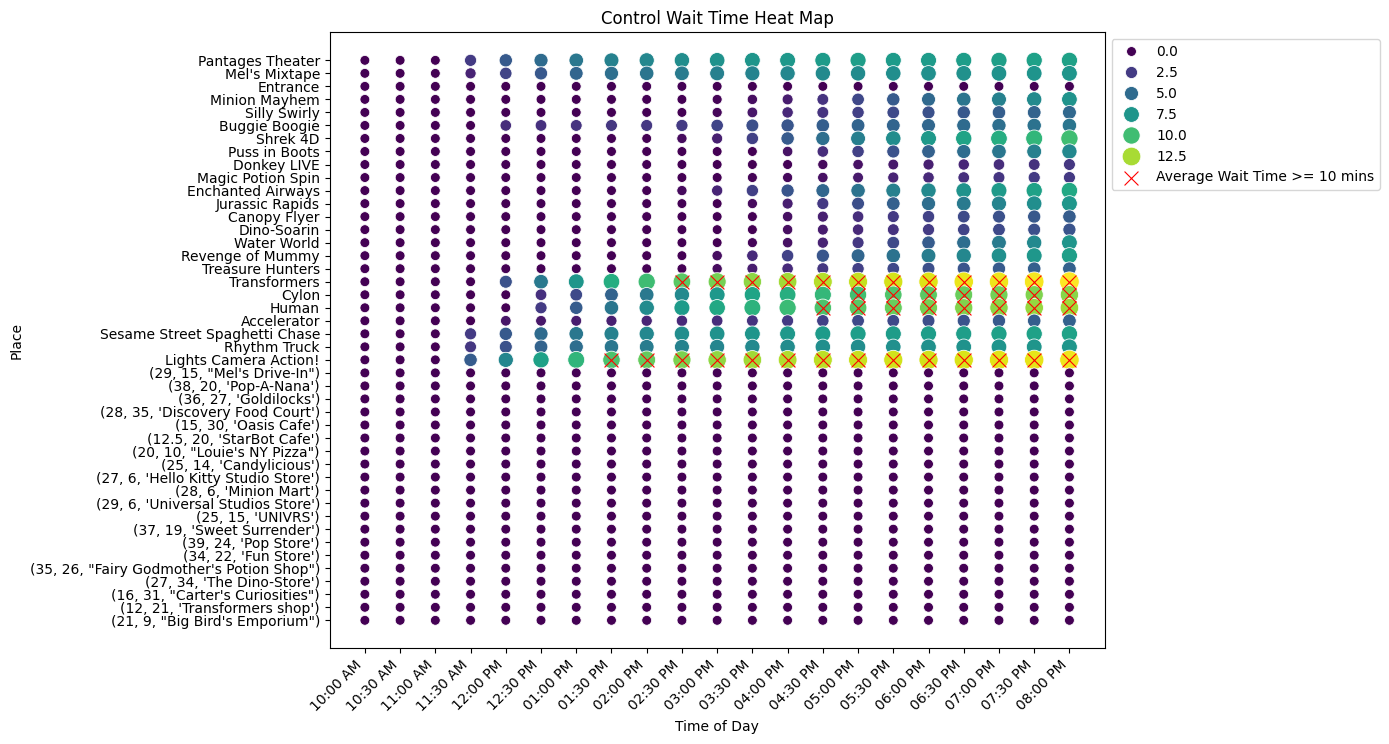

In [ ]:
# Define a threshold for 'long' wait times (using 'average' wait time)
long_wait_time_threshold = 10  # minutes (adjust as needed)

# Filter data for long wait times
long_wait_times_df = wait_times_df[wait_times_df['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

wait_times_df['place'] = wait_times_df['place'].astype(str)
long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)

# --- Control: Use time_formatted for x-axis ---
sns.scatterplot(data=wait_times_df, x='time_label', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_label', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Control Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Change 1: +10% Capacity

<ipython-input-31-f56fed20f10e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)


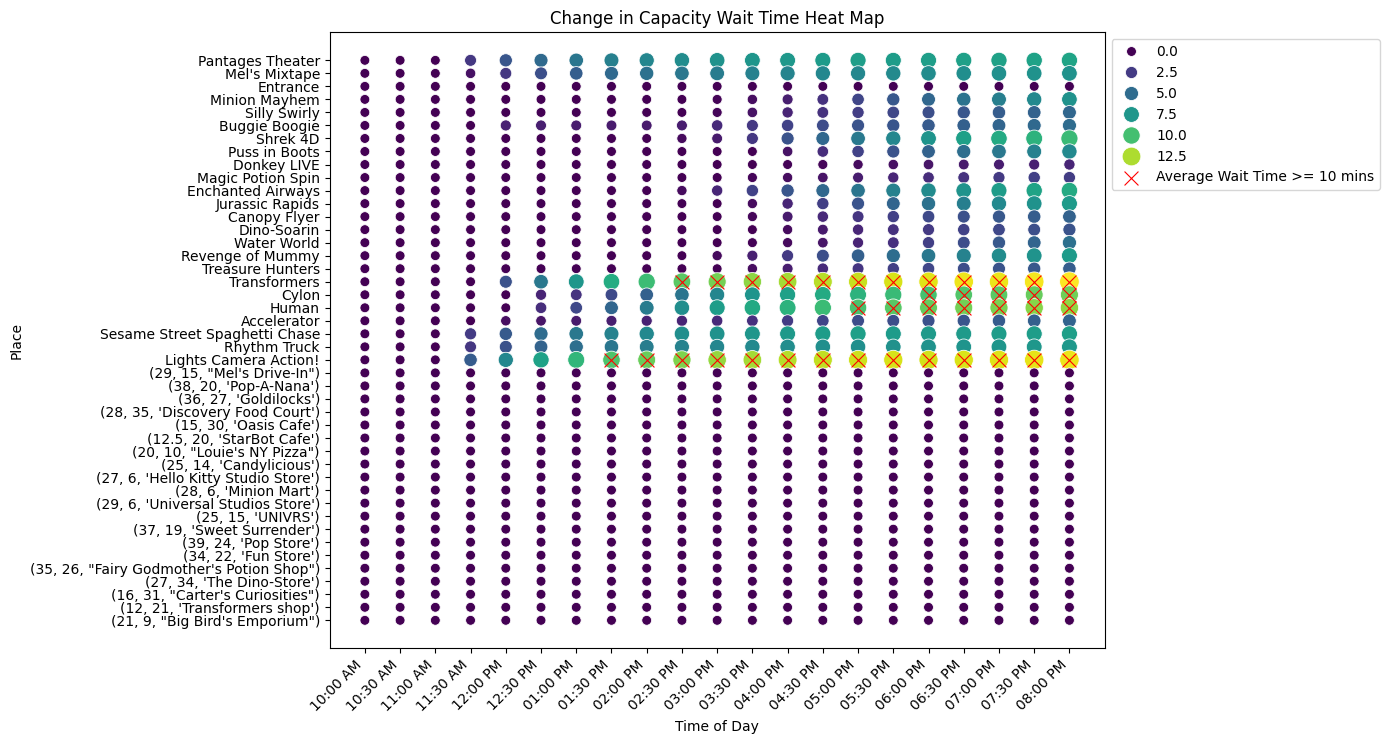

In [ ]:
# Filter data for long wait times
long_wait_times_df = change1_wait_times_df[change1_wait_times_df['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

change1_wait_times_df['place'] = change1_wait_times_df['place'].astype(str)
long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)

# --- Change 1: Use time_formatted for x-axis ---
sns.scatterplot(data=change1_wait_times_df, x='time_label', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_label', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Change in Capacity Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Change 2: Reduced Buffer Time between each ride (7 Minute for control to 5 Minute)

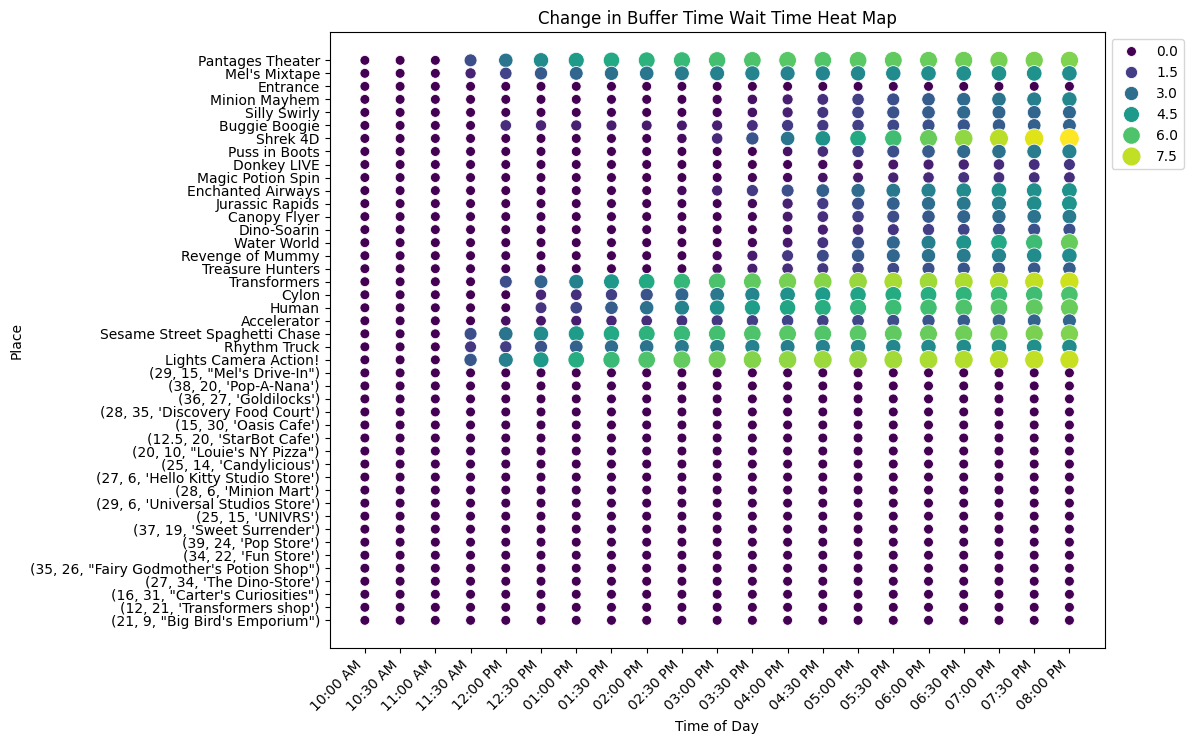

In [ ]:
# Filter data for long wait times
long_wait_times_df = change2_wait_times_df[change2_wait_times_df['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

change2_wait_times_df['place'] = change2_wait_times_df['place'].astype(str)
long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)

# --- Change 2: Use time_formatted for x-axis ---
sns.scatterplot(data=change2_wait_times_df, x='time_label', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_label', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Change in Buffer Time Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Change 3: Zone Rotation

<ipython-input-35-1cd72a0381fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)


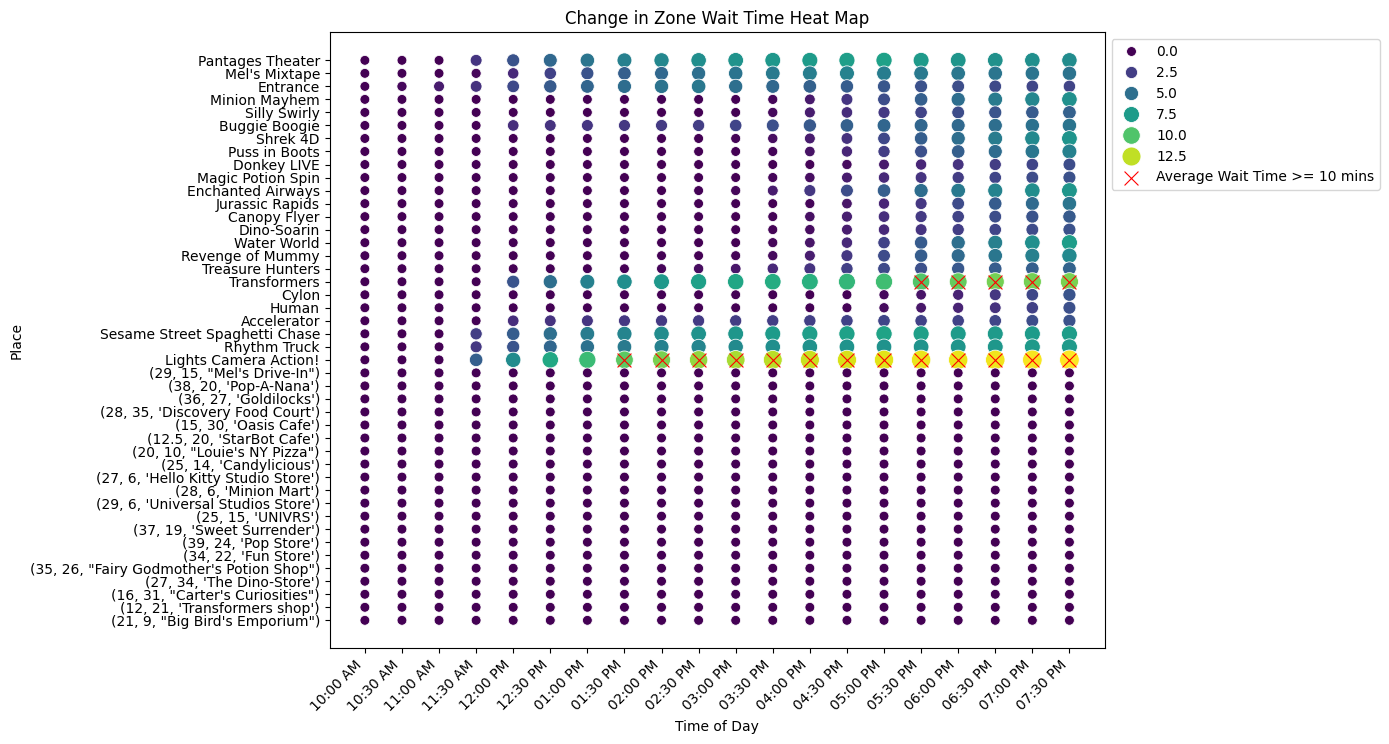

In [ ]:
# Filter data for long wait times
long_wait_times_df = change3_wait_times_df[change3_wait_times_df['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

change3_wait_times_df['place'] = change3_wait_times_df['place'].astype(str)
long_wait_times_df['place'] = long_wait_times_df['place'].astype(str)

# --- Change 3: Use time_formatted for x-axis ---
sns.scatterplot(data=change3_wait_times_df, x='time_label', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_label', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Change in Zone Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Comparison Plot for ALL: Control, C1, C2, C3

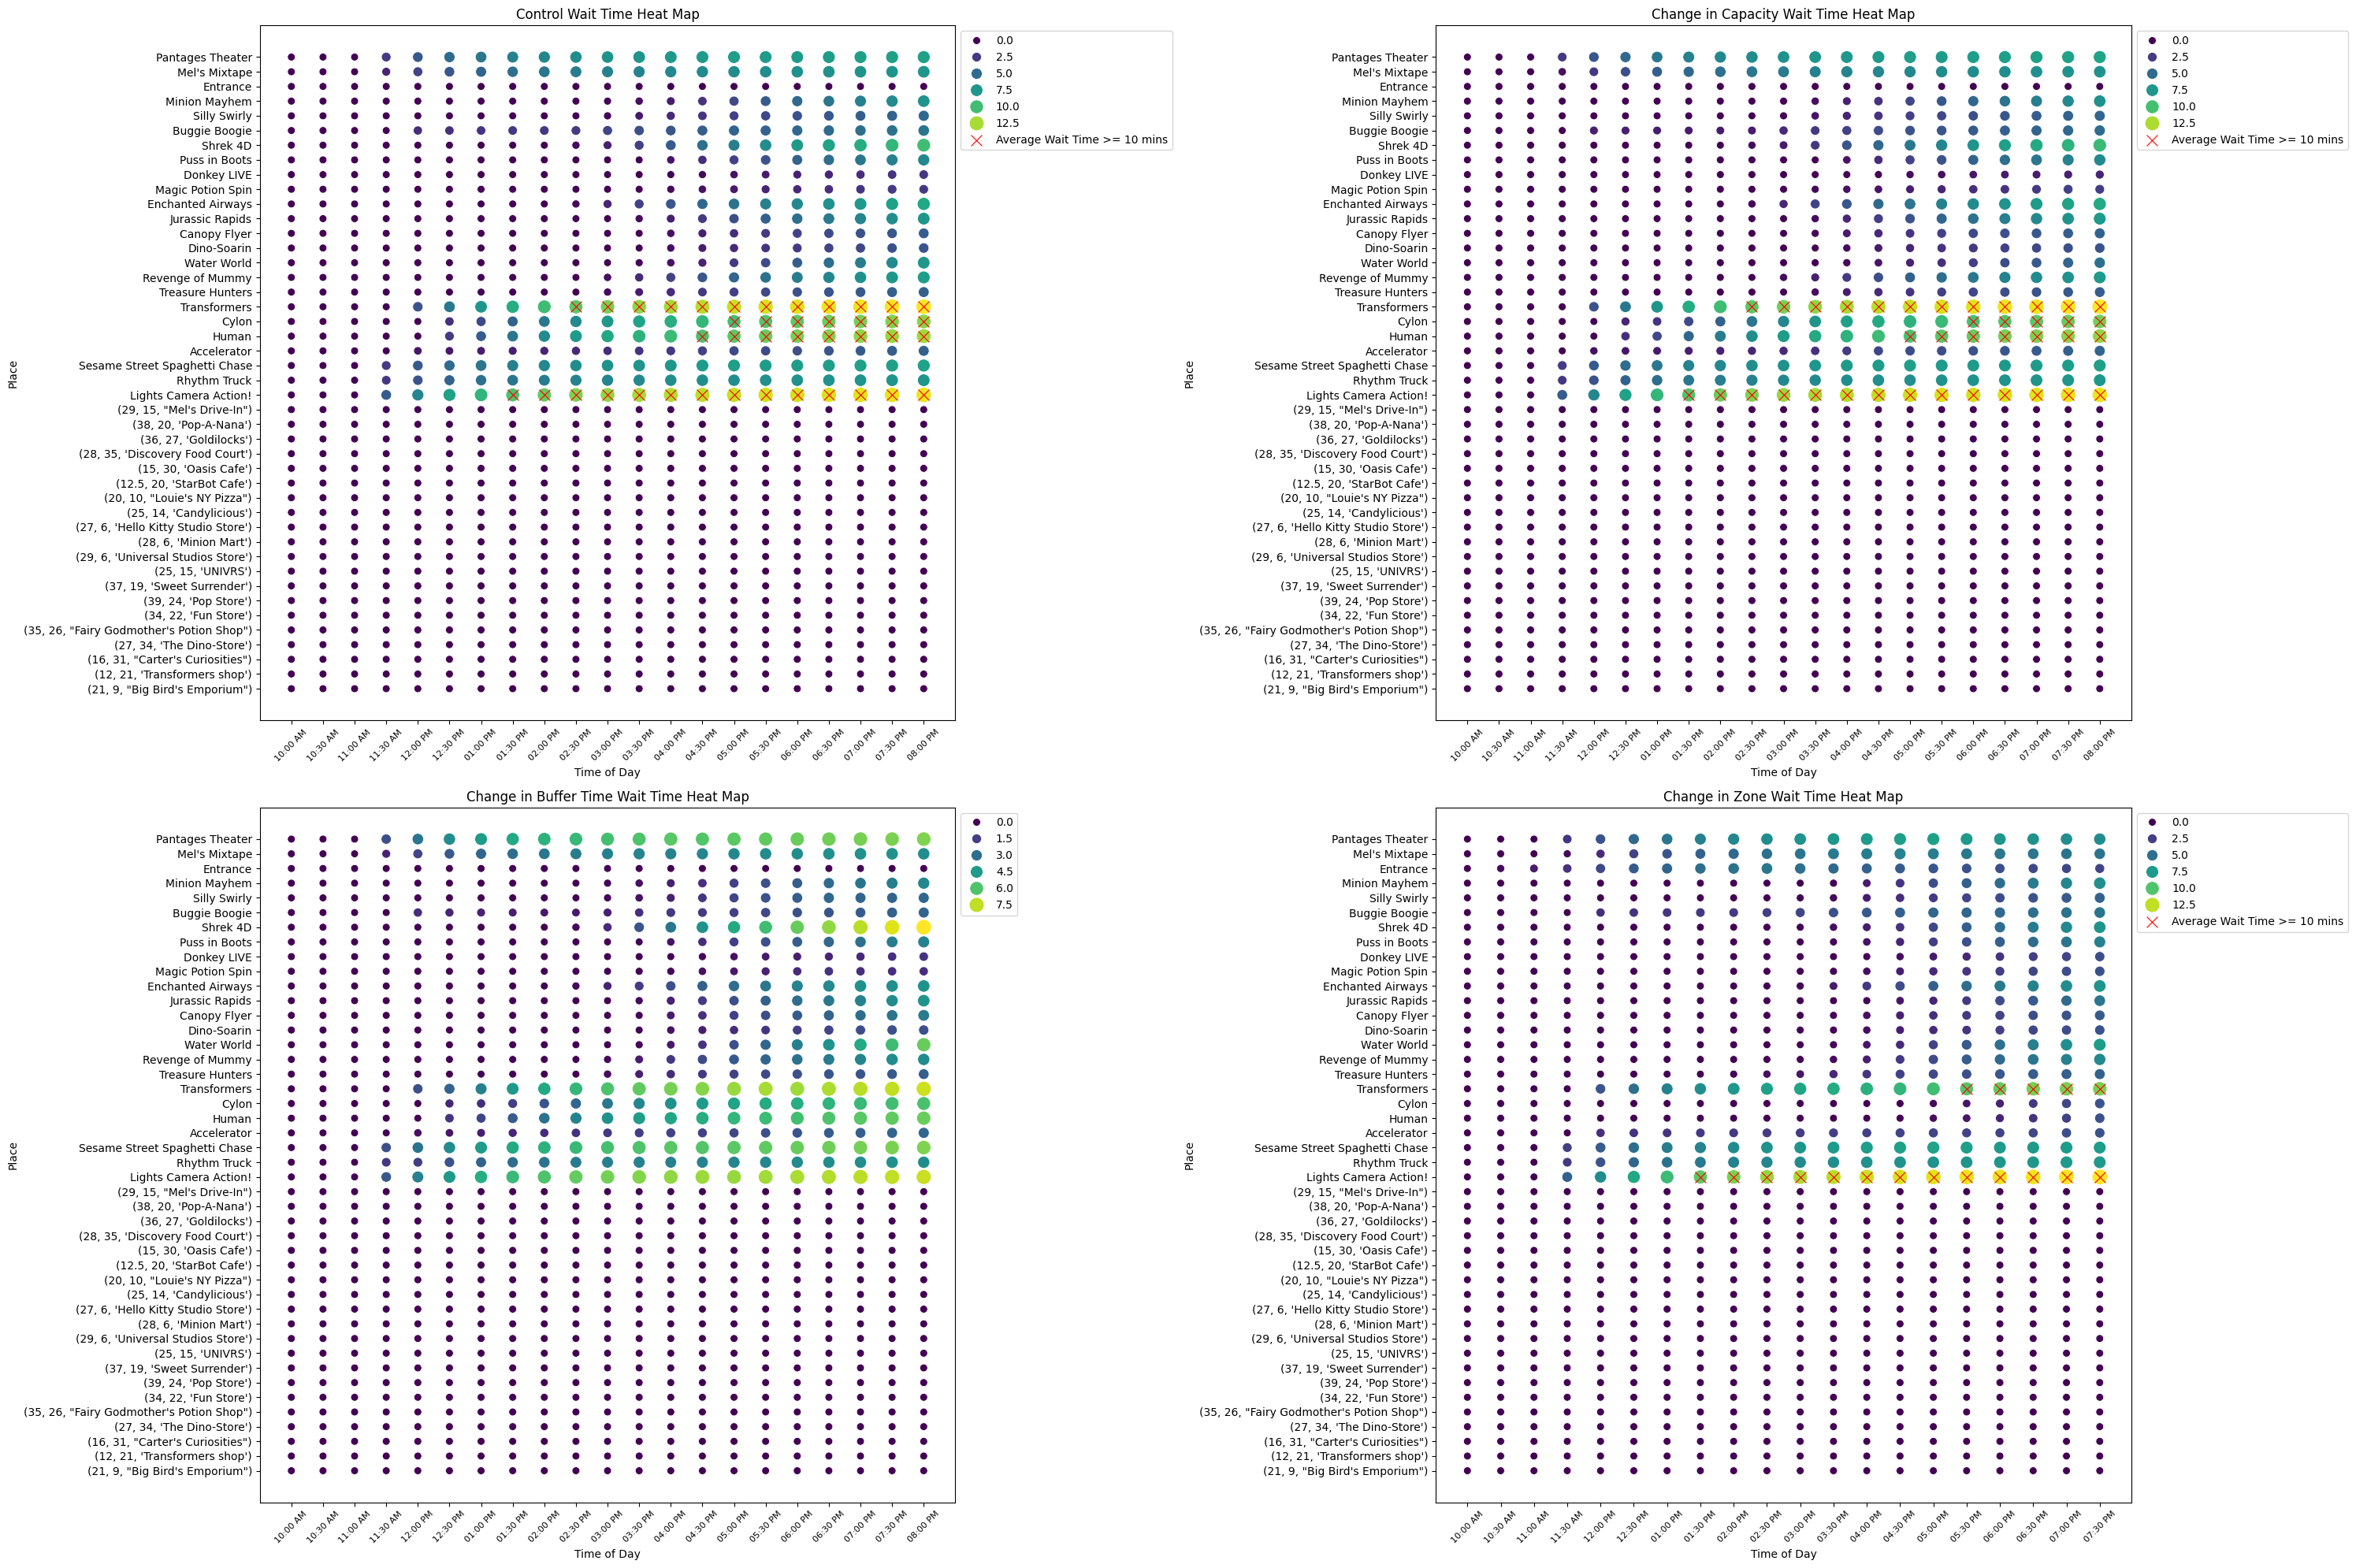

In [ ]:
# Create a figure with subplots for each scenario
fig, axes = plt.subplots(2, 2, figsize=(30, 20))

# Function to create a scatter plot for a given dataframe and subplot axis
def plot_wait_times(df, ax, title):
  long_wait_time_threshold = 10
  long_wait_times_df = df[df['average'] >= long_wait_time_threshold]

  sns.scatterplot(data=df, x='time_label', y='place', hue='average',
                  palette='viridis', size='average', sizes=(50, 200), ax=ax)
  sns.scatterplot(data=long_wait_times_df, x='time_label', y='place', color='red',
                  marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins', ax=ax)

  ax.set_title(title)
  ax.set_xlabel('Time of Day')
  ax.set_ylabel('Place')
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
  ax.tick_params(axis='x', rotation=45, labelsize=8)


# Plot each scenario in its respective subplot
plot_wait_times(wait_times_df, axes[0, 0], 'Control Wait Time Heat Map')
plot_wait_times(change1_wait_times_df, axes[0, 1], 'Change in Capacity Wait Time Heat Map')
plot_wait_times(change2_wait_times_df, axes[1, 0], 'Change in Buffer Time Wait Time Heat Map')
plot_wait_times(change3_wait_times_df, axes[1, 1], 'Change in Zone Wait Time Heat Map')


# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


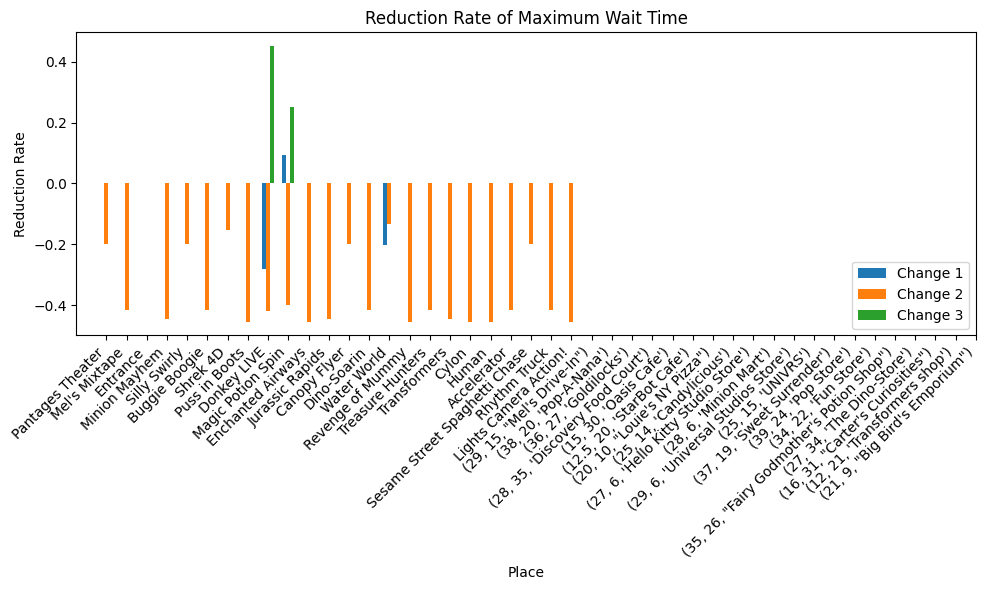

In [ ]:
# Function to calculate the rate of reduction in wait time for maximum wait time
def calculate_reduction_rate(df_base, df_change, place_name):

  base_wait_times = df_base[df_base['place'] == place_name]['maximum'].max()
  change_wait_times = df_change[df_change['place'] == place_name]['maximum'].max()

  if base_wait_times == 0:
    return float('inf')
  else:
    reduction_rate = ((change_wait_times - base_wait_times) / base_wait_times)
    return reduction_rate

# Create lists to store reduction rates for each change
c1_reduction_rates = []
c2_reduction_rates = []
c3_reduction_rates = []

# Iterate through each place and calculate the rate of reduction
places = wait_times_df['place'].unique()
for place in places:
  # Calculate reduction rates for each change compared to the control
  c1_reduction_rate = calculate_reduction_rate(wait_times_df, change1_wait_times_df, place)
  c2_reduction_rate = calculate_reduction_rate(wait_times_df, change2_wait_times_df, place)
  c3_reduction_rate = calculate_reduction_rate(wait_times_df, change3_wait_times_df, place)

  c1_reduction_rates.append(c1_reduction_rate)
  c2_reduction_rates.append(c2_reduction_rate)
  c3_reduction_rates.append(c3_reduction_rate)

  # print(f"Place: {place}")
  # print(f"  Change 1 Reduction Rate: {c1_reduction_rate}")
  # print(f"  Change 2 Reduction Rate: {c2_reduction_rate}")
  # print(f"  Change 3 Reduction Rate: {c3_reduction_rate}")

# Create a bar chart to visualize the reduction rates
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(places))

plt.bar(index, c1_reduction_rates, width=bar_width, label='Change 1')
plt.bar([i + bar_width for i in index], c2_reduction_rates, width=bar_width, label='Change 2')
plt.bar([i + 2 * bar_width for i in index], c3_reduction_rates, width=bar_width, label='Change 3')

plt.xlabel('Place')
plt.ylabel('Reduction Rate')
plt.title('Reduction Rate of Maximum Wait Time')
plt.xticks([i + bar_width for i in index], places, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


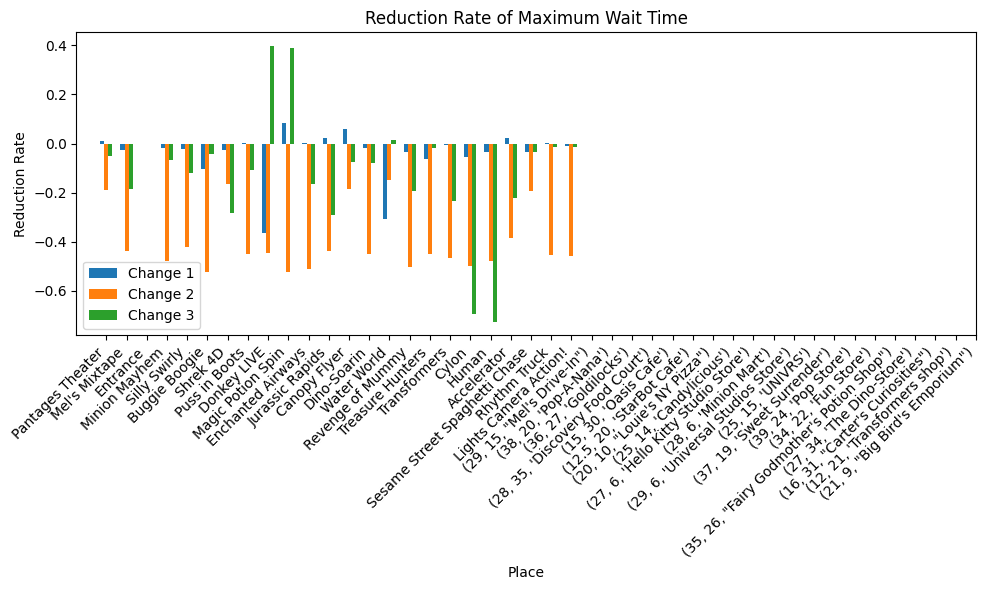

In [ ]:
def avg_calculate_reduction_rate(df_base, df_change, place_name):

  base_wait_times = df_base[df_base['place'] == place_name]['average'].max()
  change_wait_times = df_change[df_change['place'] == place_name]['average'].max()

  if base_wait_times == 0:
    return float('inf')
  else:
    reduction_rate = ((change_wait_times - base_wait_times) / base_wait_times)
    return reduction_rate

# Create lists to store reduction rates for each change
avg_c1_reduction_rates = []
avg_c2_reduction_rates = []
avg_c3_reduction_rates = []

# Iterate through each place and calculate the rate of reduction
places = wait_times_df['place'].unique()
for place in places:
  # Calculate reduction rates for each change compared to the control
  c1_reduction_rate = avg_calculate_reduction_rate(wait_times_df, change1_wait_times_df, place)
  c2_reduction_rate = avg_calculate_reduction_rate(wait_times_df, change2_wait_times_df, place)
  c3_reduction_rate = avg_calculate_reduction_rate(wait_times_df, change3_wait_times_df, place)

  avg_c1_reduction_rates.append(c1_reduction_rate)
  avg_c2_reduction_rates.append(c2_reduction_rate)
  avg_c3_reduction_rates.append(c3_reduction_rate)

  # print(f"Place: {place}")
  # print(f"  Change 1 Reduction Rate: {c1_reduction_rate}")
  # print(f"  Change 2 Reduction Rate: {c2_reduction_rate}")
  # print(f"  Change 3 Reduction Rate: {c3_reduction_rate}")

# Create a bar chart to visualize the reduction rates
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(places))

plt.bar(index, avg_c1_reduction_rates, width=bar_width, label='Change 1')
plt.bar([i + bar_width for i in index], avg_c2_reduction_rates, width=bar_width, label='Change 2')
plt.bar([i + 2 * bar_width for i in index], avg_c3_reduction_rates, width=bar_width, label='Change 3')

plt.xlabel('Place')
plt.ylabel('Reduction Rate')
plt.title('Reduction Rate of Maximum Wait Time')
plt.xticks([i + bar_width for i in index], places, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Assess of Wait Time on Guest Satisfaction

Show that reduced wait times increases overall guest satisfaction:

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


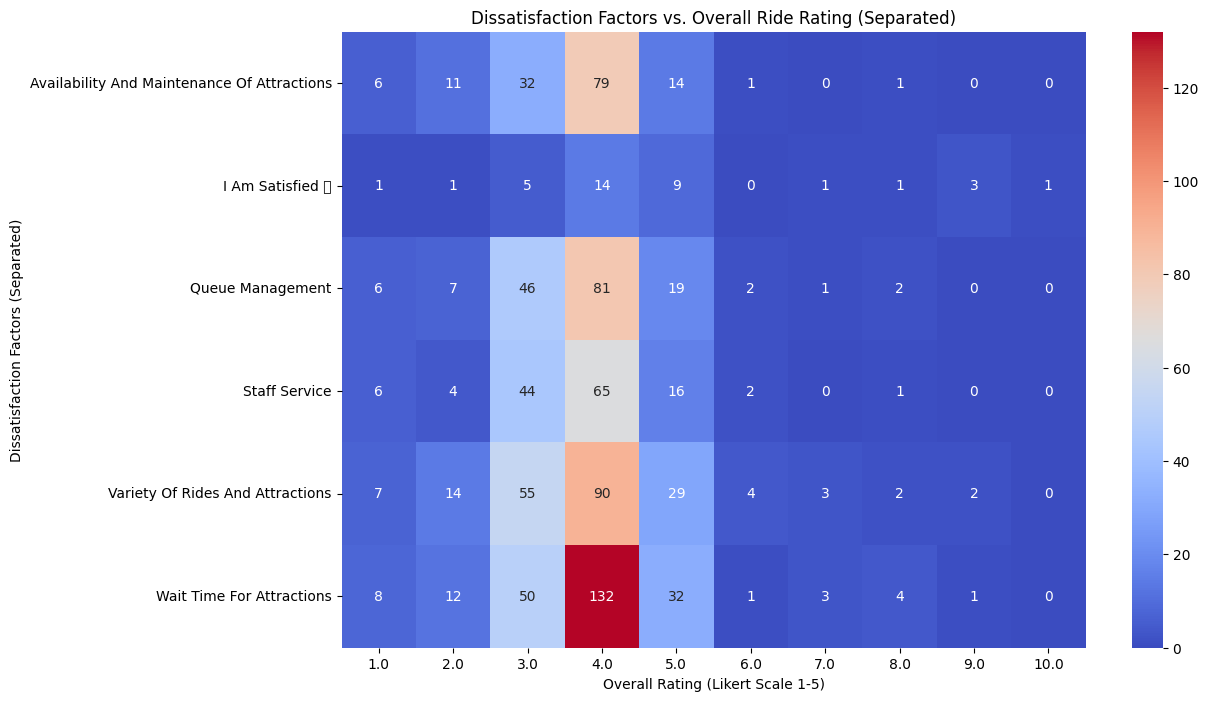

In [ ]:
### RIDES AND ATTRACTION:

rating_col = "Question 17.2: Give an overall rating for rides and attractions"  # Column storing Likert scale ratings (1-5)
dissatisfaction_col = "Question 18.2: For rides and attractions, which of the following services are you not satisfied with?"  # Column storing dissatisfaction reasons

# Create a list to store new DataFrame rows
new_rows = []

for index, row in survey_data.iterrows():
    dissatisfaction_reasons = str(row[dissatisfaction_col]).split(',')  # Split by comma
    for reason in dissatisfaction_reasons:
        reason = reason.strip()  # Remove leading/trailing spaces
        if reason:  # If reason is not empty
            new_row = row.copy()  # Create a copy of the original row
            new_row[dissatisfaction_col] = reason  # Assign the single reason
            new_rows.append(new_row)

# Create a new DataFrame with separated reasons
separated_data = pd.DataFrame(new_rows)

# Filter out unwanted reasons
filtered_data = separated_data[~separated_data[dissatisfaction_col].isin(["Not taking into account soft toy like me!", "nan"])]

# Group by rating and dissatisfaction reason and count occurrences
dissatisfaction_counts = filtered_data.groupby([rating_col, dissatisfaction_col]).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(dissatisfaction_counts.T, cmap="coolwarm", annot=True, fmt="d")
plt.xlabel("Overall Rating (Likert Scale 1-5)")
plt.ylabel("Dissatisfaction Factors (Separated)")
plt.title("Dissatisfaction Factors vs. Overall Ride Rating (Separated)")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


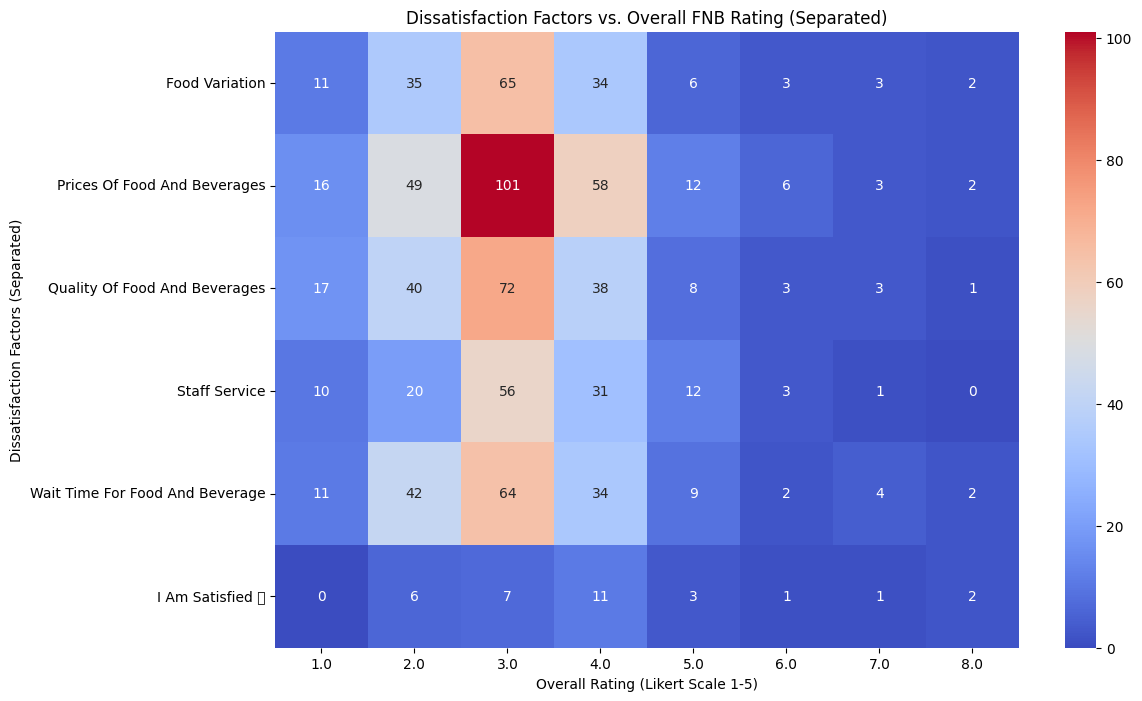

In [ ]:
### FNB

rating_col = "Question 17.4: Give an overall rating for food and beverage"  # Column storing Likert scale ratings (1-5)
dissatisfaction_col = "Question 18.4: For food and beverage, which of the following services are you not satisfied with?"  # Column storing dissatisfaction reasons

# Create a list to store new DataFrame rows
new_rows = []

for index, row in survey_data.iterrows():
    dissatisfaction_reasons = str(row[dissatisfaction_col]).split(',')  # Split by comma
    for reason in dissatisfaction_reasons:
        reason = reason.strip()  # Remove leading/trailing spaces
        if reason:  # If reason is not empty
            new_row = row.copy()  # Create a copy of the original row
            new_row[dissatisfaction_col] = reason  # Assign the single reason
            new_rows.append(new_row)

# Create a new DataFrame with separated reasons
separated_data = pd.DataFrame(new_rows)

# Filter out unwanted reasons
filtered_data = separated_data[~separated_data[dissatisfaction_col].isin(["nan"])]

# Group by rating and dissatisfaction reason and count occurrences
dissatisfaction_counts = filtered_data.groupby([rating_col, dissatisfaction_col]).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(dissatisfaction_counts.T, cmap="coolwarm", annot=True, fmt="d")
plt.xlabel("Overall Rating (Likert Scale 1-5)")
plt.ylabel("Dissatisfaction Factors (Separated)")
plt.title("Dissatisfaction Factors vs. Overall FNB Rating (Separated)")
plt.show()